In [68]:
import os

import dask_geopandas as ddg
import fiona
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa

In [35]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [38]:
cmap = plt.get_cmap('cubehelix', 11)
new_cmap = truncate_colormap(cmap, 0.2, 0.75)

In [47]:
## Set-up
data_path = '/nas/cee-water/cjgleason/data/NHDPlus_HR/'
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
save_path = '../narrow_rivers_PIXC_data/NHD_prepped/'
# Max binsize of 1000 is plenty for CONUS w/o lakes
# Mississippi is ~472 m wide at mouth as calculated here
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 500, 1000]

In [48]:
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
lookup = pd.read_csv(os.path.join(mdata_path,
                                  'HUC4_lookup_no_great_lakes.csv'),
                     dtype=dtype_dic)

In [49]:
# Get slurm job index
i = 4

In [50]:
# Get current HUC2 and HUC4 IDs
huc2 = 'HUC2_' + lookup.loc[i,'HUC4'][0:2]
huc4 = 'NHDPLUS_H_' + lookup.loc[i,'HUC4'] + '_HU4_GDB'

In [51]:
# Set data filepath
file_path = os.path.join(data_path, huc2, huc4, huc4 + '.gdb')

In [61]:
# fiona.listlayers(file_path)

In [7]:
# # Set write filepath
# save_path = os.path.join(save_path, huc2)
# save_file = huc4 + '_prepped.gpkg' ## CHANGE

In [52]:
## Prep Physiographic Regions
# https://www.sciencebase.gov/catalog/item/631405bbd34e36012efa304e
physio = gpd.read_file(filename=os.path.join(data_path,
                                             'other_shapefiles/physio.shp'),
                       engine='pyogrio')
# Set CRS to Web Mercator
physio = physio.to_crs(epsg=3857)
# Dissolve provinces by division
physio = physio.dissolve(by='DIVISION').reset_index()
# Drop all columns besides division and geometry
physio = physio[['DIVISION', 'geometry']]

In [53]:
## Get bankfull width coefficients from Bieber et al. 2015, Table 3
bankfull = pd.read_csv(os.path.join(mdata_path,
                                    'bieger_2015_bankfull_width.csv'))

In [54]:
## Merging
# Read in NHD flowlines
basin = gpd.read_file(filename=file_path, layer='NHDFlowline', engine='pyogrio')
# Set CRS to Pseudo-Mercator https://epsg.io/3857
basin = basin.to_crs(epsg=3857)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(


In [55]:
basin

,Permanent_Identifier,FDate,Resolution,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FlowDir,WBArea_Permanent_Identifier,FType,FCode,MainPath,InNetwork,VisibilityFilter,Shape_Length,NHDPlusID,VPUID,Enabled,geometry
0,{69AD3389-7F99-4FFD-A48F-9D88CFD0697E},2012-03-03 04:43:24+00:00,2,None,None,0.359000,01080203003307,1,None,460,46006,0,1,50000,0.003548,1.000090e+13,0108,1,"MULTILINESTRING Z ((-8132916.01 5289901.543 0,..."
1,{0230A63E-2662-48E7-8D75-E9CEE83654B8},2012-03-03 03:45:26+00:00,2,None,None,0.604000,01080106009103,1,None,460,46006,0,1,24000,0.006087,1.000090e+13,0108,1,MULTILINESTRING Z ((-8061020.932 5374240.653 0...
2,{0139CA56-4C10-4882-AE89-433721AA7DD3},2013-08-13 00:00:00+00:00,2,None,None,0.317466,01080105006146,1,{9FF5F8AA-40B5-4FEB-9CEE-64C775671D7E},558,55800,0,1,50000,0.003028,1.000090e+13,0108,1,MULTILINESTRING Z ((-8083828.358 5473168.178 0...
3,{01489C1F-05B4-4DD2-B514-BCAFFE14F51B},2015-01-16 00:00:00+00:00,2,None,None,0.011722,01080102000724,1,{E9182870-79E0-4CFB-93A9-0226B10FC4BC},558,55800,0,1,50000,0.000130,1.000090e+13,0108,1,MULTILINESTRING Z ((-8018627.084 5542898.946 0...
4,{1C5C6F84-B49F-46CF-8672-DA428DCA1898},2014-12-02 00:00:00+00:00,2,None,None,0.073721,01080104002973,1,{BD6141A2-D017-4E6A-B572-083BE0E9F17E},558,55800,0,1,24000,0.000906,1.000090e+13,0108,1,MULTILINESTRING Z ((-8055402.943 5462406.454 0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99072,91151349,2015-05-01 00:00:00+00:00,2,00870133,Stalbird Brook,0.194641,01080101000125,1,None,460,46006,0,1,1000000,0.002246,1.000090e+13,0108,1,"MULTILINESTRING Z ((-7960386.79 5534231.437 0,..."
99073,91151903,2012-03-03 02:09:35+00:00,2,None,None,2.661000,01080101003132,1,None,460,46003,0,1,50000,0.029875,1.000090e+13,0108,1,MULTILINESTRING Z ((-7951969.936 5527770.608 0...
99074,91152015,2012-03-03 02:10:14+00:00,2,None,None,1.603000,01080101003160,1,None,460,46003,0,1,24000,0.016895,1.000090e+13,0108,1,MULTILINESTRING Z ((-7945927.353 5522423.902 0...
99075,91141175,2012-03-03 02:09:54+00:00,2,None,None,0.464000,01080101001412,1,None,460,46003,0,1,24000,0.005085,1.000090e+13,0108,1,MULTILINESTRING Z ((-7930094.548 5646183.585 0...


(5150000.0, 5250000.0)

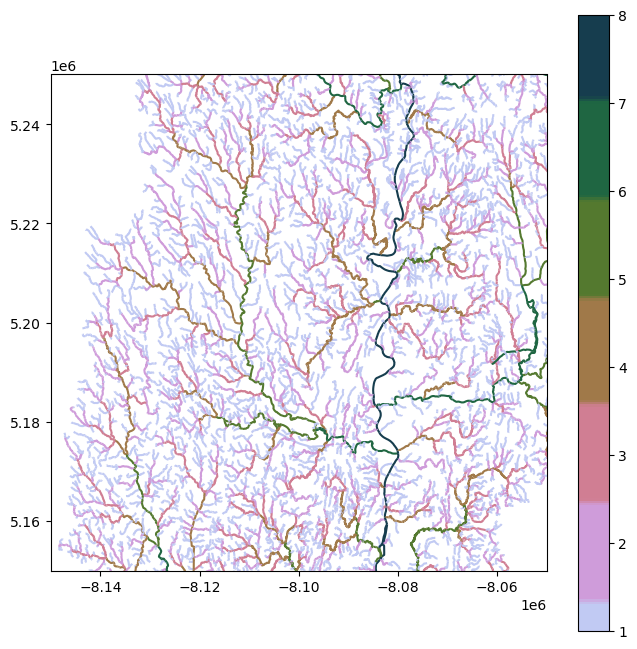

In [46]:
fig, ax = plt.subplots(figsize=(8,8))

basin.plot(ax=ax, column='StreamOrde',
           cmap=new_cmap.reversed(), legend=True)

plt.xlim(-8150000, -8050000)
plt.ylim(5150000, 5250000)

In [56]:
# Read in VAA
vaa = gpd.read_file(filename=file_path, layer='NHDPlusFlowlineVAA', engine='pyogrio')
# Merge on VAA
basin = basin.merge(right=vaa, how='inner', on=['NHDPlusID', 'VPUID', 'ReachCode'])

# Read in EROMMA
eromma = gpd.read_file(filename=file_path, layer='NHDPlusEROMMA', engine='pyogrio')
# Merge on EROMMA
basin = basin.merge(right=eromma, how='inner', on=['NHDPlusID', 'VPUID'])

In [57]:
vaa.columns

Index(['NHDPlusID', 'StreamLeve', 'StreamOrde', 'StreamCalc', 'FromNode',
       'ToNode', 'HydroSeq', 'LevelPathI', 'PathLength', 'TerminalPa',
       'ArbolateSu', 'Divergence', 'StartFlag', 'TerminalFl', 'UpLevelPat',
       'UpHydroSeq', 'DnLevel', 'DnLevelPat', 'DnHydroSeq', 'DnMinorHyd',
       'DnDrainCou', 'FromMeas', 'ToMeas', 'ReachCode', 'RtnDiv', 'Thinner',
       'VPUIn', 'VPUOut', 'AreaSqKm', 'TotDASqKm', 'DivDASqKm', 'MaxElevRaw',
       'MinElevRaw', 'MaxElevSmo', 'MinElevSmo', 'Slope', 'SlopeLenKm',
       'ElevFixed', 'HWType', 'HWNodeSqKm', 'StatusFlag', 'VPUID'],
      dtype='object')

In [58]:
eromma.columns

Index(['NHDPlusID', 'QAMA', 'VAMA', 'QIncrAMA', 'QBMA', 'VBMA', 'QIncrBMA',
       'QCMA', 'VCMA', 'QIncrCMA', 'QDMA', 'VDMA', 'QIncrDMA', 'QEMA', 'VEMA',
       'QIncrEMA', 'QFMA', 'QIncrFMA', 'ArQNavMA', 'PETMA', 'QLossMA',
       'QGAdjMA', 'QGNavMA', 'GageAdjMA', 'AvgQAdjMA', 'GageIDMA', 'GageQMA',
       'VPUID'],
      dtype='object')

In [13]:
## Filtering
# Read in NHD Waterbody polygons
area = gpd.read_file(filename=file_path, layer='NHDWaterbody',
                     columns=['NHDPlusID', 'geometry'], engine='pyogrio')

# Set CRS to Pseudo-Mercator https://epsg.io/3857
area = area.to_crs(epsg=3857)

In [14]:
# Find all flowlines within waterbodies
subset = basin.sjoin(df=area, how='inner', predicate='within')
# Get IDs of these flowlines
ids = subset.NHDPlusID_left.to_list()

In [62]:
basin.FType.unique()

array([460, 558, 334, 336, 428, 420], dtype=int32)

In [15]:
# Drop reaches within waterbodies
basin = basin[~basin.NHDPlusID.isin(ids)]
# Drop reaches that aren't stream types or artificial path
basin = basin.loc[(basin.FType == 460) | (basin.FType == 558)]
# Drop reaches that are terminal paths
basin = basin.loc[basin.TerminalFl == 0]
# Drop reaches with discharge of zero
basin = basin.loc[basin.QBMA > 0]
# Drop reaches with stream order of zero
basin = basin.loc[basin.StreamOrde > 0]

In [16]:
## Find the physiographic division each reach is within
# Note: there is broken topology even after the dissolve,
# and neither shapely nor sf fully repaired it
basin = basin.sjoin(df=physio, how='left',
                    predicate='intersects').drop(columns='index_right')
# Drop all reaches where DIVISION == NaN (in Canada and at the coasts)
basin = basin[~basin.DIVISION.isnull()]

In [18]:
## Get bankfull widths
# Merge on bankfull width coefficient
basin = basin.merge(bankfull, on='DIVISION', how='left')
# Calculate width from cumulative drainage area
basin['WidthM'] = basin.a*basin.TotDASqKm**basin.b

In [24]:
### NEW
# Calculate the multiplicative factor from the standard error
# of estimate for each physiographic division (SEEpd) by exponentiation
basin['mul_factor'] = 10**basin.see_phys
# Calculate the min width of each reach
basin['WidthM_Min'] = basin.WidthM/basin.mul_factor
# Calculate the max width of each basin
basin['WidthM_Max'] = basin.WidthM*basin.mul_factor

In [39]:
# Drop reaches that are shorter than their width
basin = basin[basin['LengthKM']*1000 > basin['WidthM']]

In [43]:
## Bin reaches by width, set to string for parquet
basin['Bin'] = pd.cut(basin['WidthM'], bins).astype(str)
basin['Bin_Min'] = pd.cut(basin['WidthM_Min'], bins).astype(str)
basin['Bin_Max'] = pd.cut(basin['WidthM_Max'], bins).astype(str)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
pd.set_option('display.max_rows', 95)

In [45]:
basin.dtypes

Permanent_Identifier                 object
FDate                   datetime64[ms, UTC]
Resolution                            int32
GNIS_ID                              object
GNIS_Name                            object
                               ...         
WidthM                              float64
mul_factor                          float64
WidthM_Min                          float64
WidthM_Max                          float64
Bin                                  object
Length: 96, dtype: object